In [1]:
import os, h5py
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
import torch 
import copy
from sbi import utils as Ut
from sbi import inference as Inference

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

seed = 12387
torch.manual_seed(seed)
if cuda: 
    torch.cuda.manual_seed(seed)

# 1. load $\theta$ and $m(\theta)$

In [5]:
dat_dir = '/scratch/gpfs/chhahn/21cmlfi/'
f = h5py.File(os.path.join(dat_dir, '21cmlfi.hdf5'), 'r')

thetas = f['theta'][...]
# Delta^2_21(z = 7.926647, 10.09916, 12.00443, 13.938, 16.15907, 17.945, 19.91681)
del2_nonoise = f['Del2_21_nonoise'][...]

f.close()

# 2. noise model 
$$\Delta^2_{21}(\theta', \sigma, s) = m(\theta') + \epsilon'_{\rm thermal} + \epsilon'_{\rm systematics}$$
where $\epsilon'_{\rm thermal} = \mathcal{N}(0, \sigma)$ and $\epsilon'_{\rm systematics} = \mathcal{U}(0, s)$

In [6]:
def apply_noise(model, sigma, systematics): 
    ''' apply noise model t
    '''
    eps_t = sigma * np.random.normal(size=model.shape)
    eps_s = systematics * np.random.uniform(size=model.shape)
    
    return model + eps_t + eps_s

# 3. Forecast 


## 3.1 current HERA

Generate noisy $\Delta^2_{21}$
$$\Delta_{21}^2(k=0.17 {\rm Mpc}^{-1}, z=7.9) = 200, \Delta^2_{21}(k=0.17 {\rm Mpc}^{-1}, z=10.1) = 1700$$
$$\sigma_{z = 7.9} = 300, \sigma_{z = 10.1} = 3600$$
$$s_{z = 7.9} = 200, s_{z = 10.1} = 1700$$

In [7]:
del2_obs = np.array([200., 1700.])
del2_noise = apply_noise(del2_nonoise[:,:2], np.array([300., 3600.]), del2_obs)

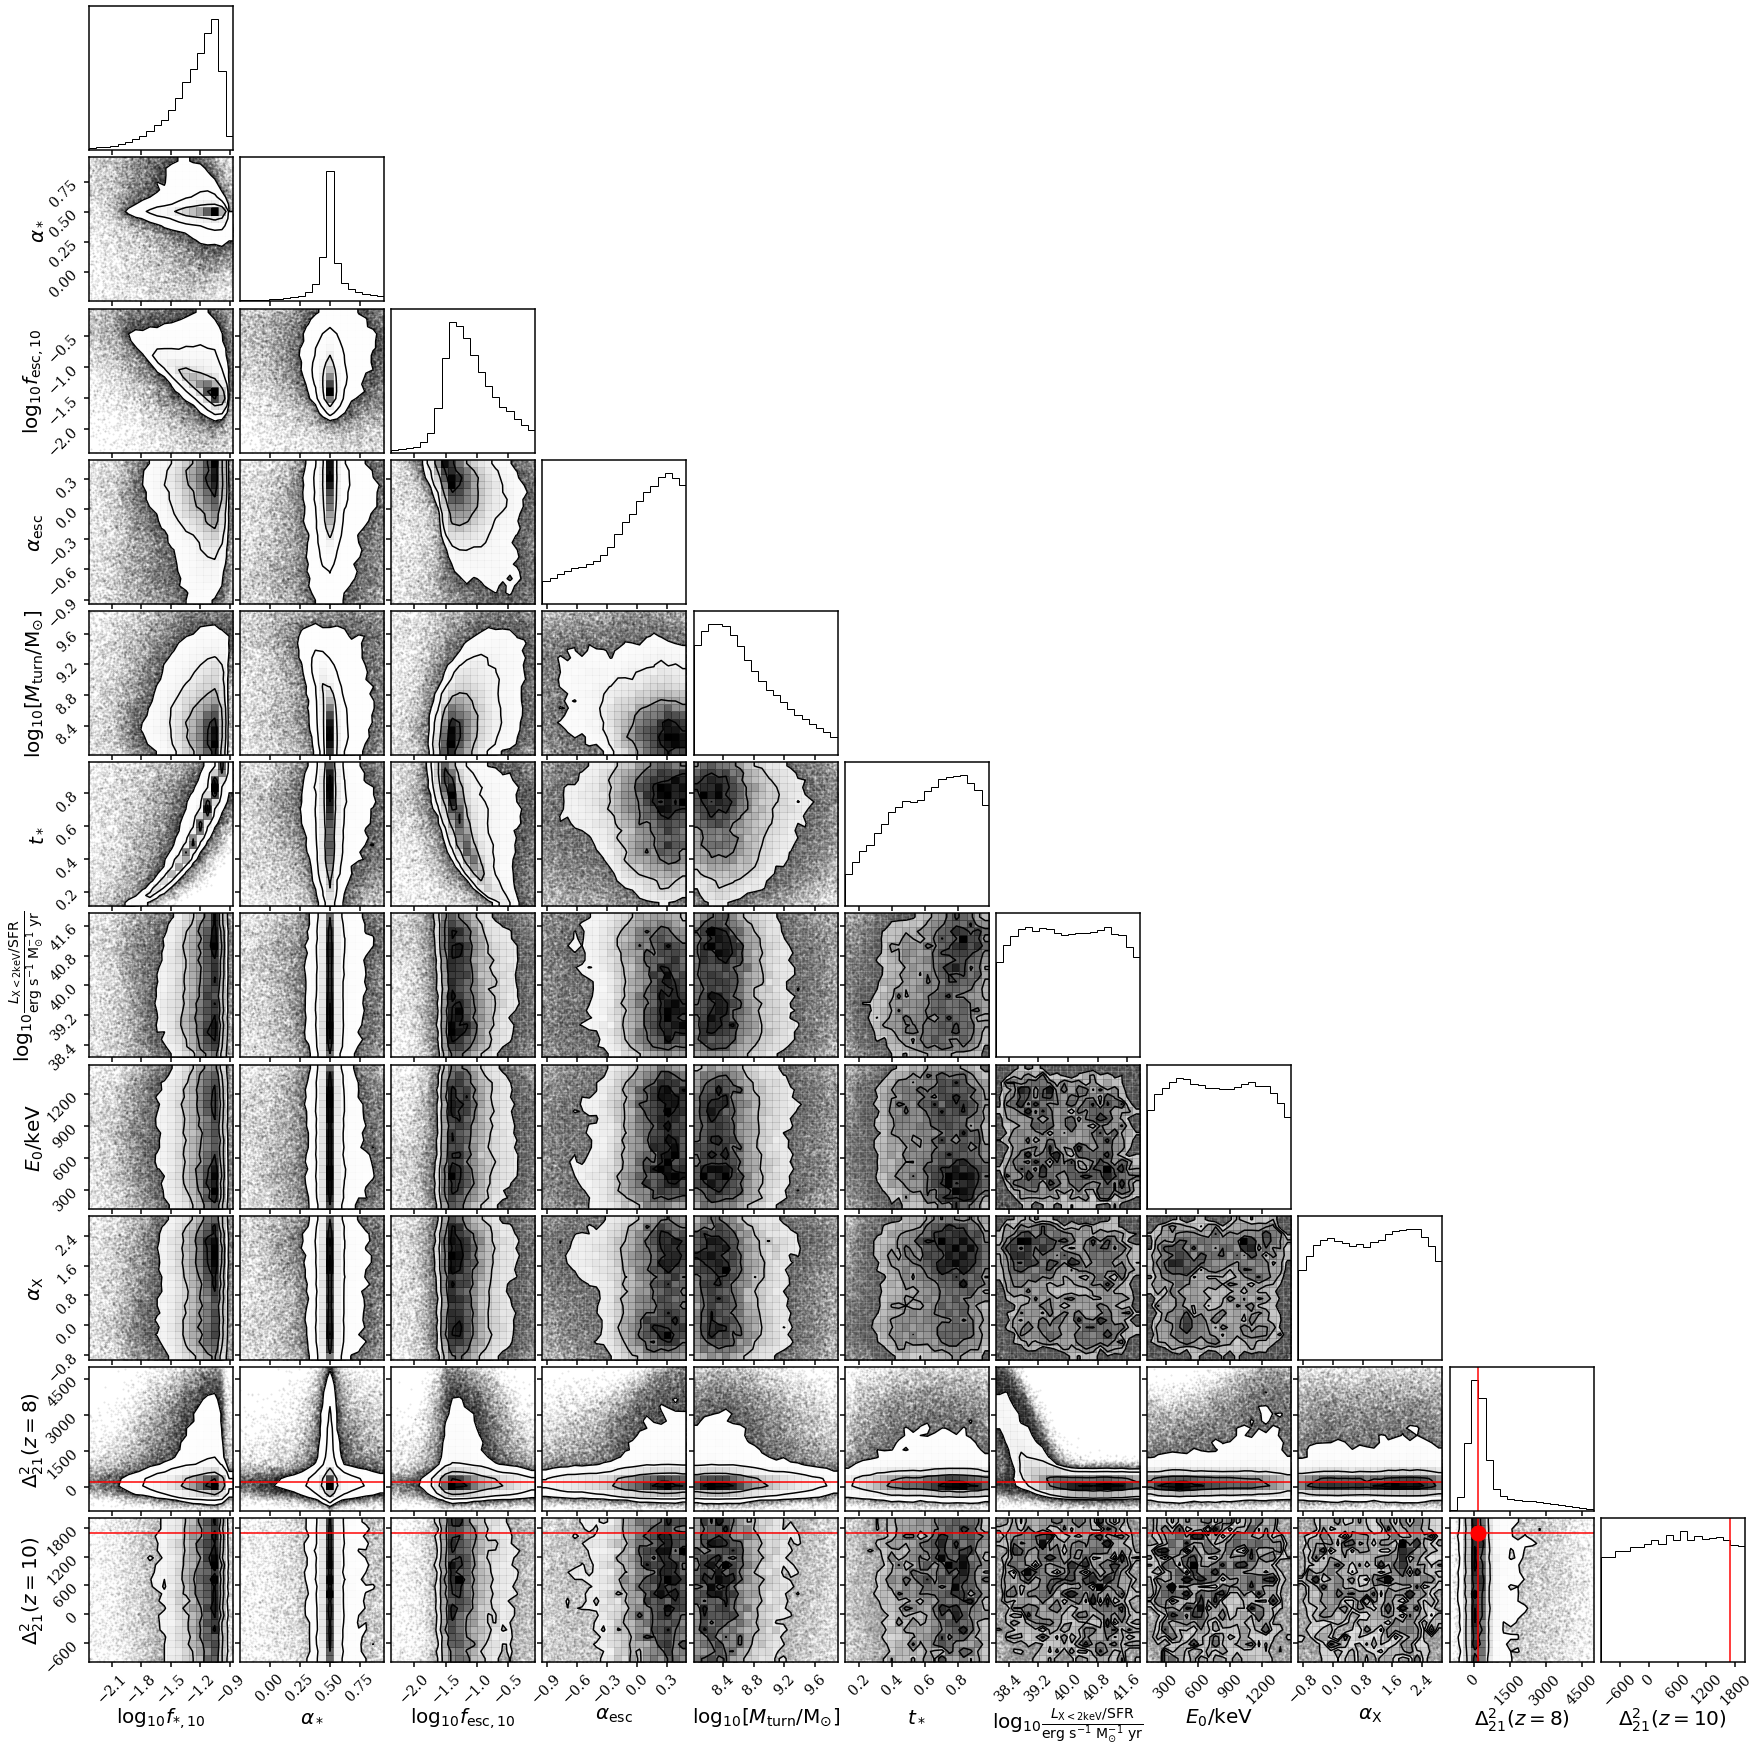

In [8]:
lbl_params = np.array([r"$\log_{10} f_{*,10}$",
                       r"$\alpha_*$",
                       r"$\log_{10} f_{\rm esc, 10}$",
                       r"$\alpha_{\rm esc}$",
                       r"$\log_{10}[M_{\rm turn}/{\rm M}_{\odot}]$",
                       r"$t_*$",
                       r"$\log_{10}\frac{L_{\rm X<2keV}/{\rm SFR}}{{\rm erg\ s^{-1}\ M_{\odot}^{-1}\ yr}}$",
                       r"$E_0/{\rm keV}$",
                       r"$\alpha_{\rm X}$"])

prior_params = [[-3,0], [-0.5,1], [-3,0],[-1,0.5], [8,10], [0.01,1], [38,42], [0.1,1.5], [-1,3]]

fig = DFM.corner(np.concatenate([thetas, del2_noise], axis=1), 
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T] + [(-1000., 5000), (-1000., 2000)],  
                 labels=list(lbl_params) + [r'$\Delta_{21}^2(z=8)$', r'$\Delta_{21}^2(z=10)$'],
                 label_kwargs={'fontsize': 20})
DFM.overplot_points(fig, [[None for _ in lbl_params] + list(del2_obs)], color='r', markersize=30)
DFM.overplot_lines(fig, [None for _ in lbl_params] + list(del2_obs), color='r')

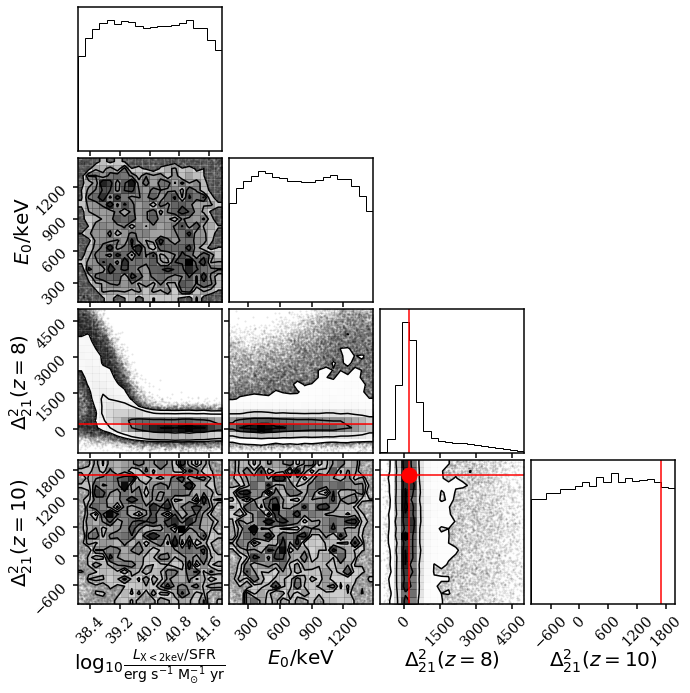

In [9]:
fig = DFM.corner(np.concatenate([thetas[:,6:8], del2_noise], axis=1), 
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T[6:8]] + [(-1000., 5000), (-1000., 2000)],  
                 labels=list(lbl_params[6:8]) + [r'$\Delta_{21}^2(z=8)$', r'$\Delta_{21}^2(z=10)$'],
                 label_kwargs={'fontsize': 20})
DFM.overplot_points(fig, [[None, None] + list(del2_obs)], color='r', markersize=30)
DFM.overplot_lines(fig, [None, None] + list(del2_obs), color='r')

Train NPE

In [10]:
# set priors 
prior_params = [[-3,0], [-0.5,1], [-3,0],[-1,0.5], [8,10], [0.01,1], [38,42], [100.,1500.], [-1,3]]
lower_bounds = torch.tensor([_p[0] for _p in prior_params])
upper_bounds = torch.tensor([_p[1] for _p in prior_params])

prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device=("cuda" if cuda else "cpu"))

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "


In [11]:
def train_npe(thetas, obs, n_models=3): 
    '''
    '''
    phats, best_valid_logprobs = [], []
    for i in range(n_models):
        nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(128)))))
        nblocks = int(np.random.uniform(3, 10))
        print('MAF with nhidden=%i; nblocks=%i' % (nhidden, nblocks))
        arch = '%ix%i' % (nhidden, nblocks)

        anpe = Inference.SNPE(prior=prior,
                              density_estimator=Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks),
                              device=("cuda" if cuda else "cpu"))
        anpe.append_simulations(
            torch.as_tensor(thetas.astype(np.float32)),
            torch.as_tensor(obs.astype(np.float32)))

        _phat = anpe.train(training_batch_size=256)

        p_theta_obs_est = anpe.build_posterior(_phat)
        
        phats.append(p_theta_obs_est)
        best_valid_logprobs.append(anpe._summary['best_validation_log_probs'])

    ibest = np.argmax(best_valid_logprobs)
    return copy.deepcopy(phats[ibest])

In [12]:
phat = train_npe(thetas, del2_noise, n_models=1)

MAF with nhidden=88; nblocks=4


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:684: UserWarning: Data x has device 'cpu' different from the training_device 'cuda:0', moving x to the training_device 'cuda:0'.
  f"Data x has device '{x.device}' "
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:692: UserWarning: Parameters theta has device 'cpu' different from the training_device 'cuda:0', moving theta to the training_device 'cuda:0'.
  f"Parameters theta has device '{theta.device}' "


 Neural network successfully converged after 163 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

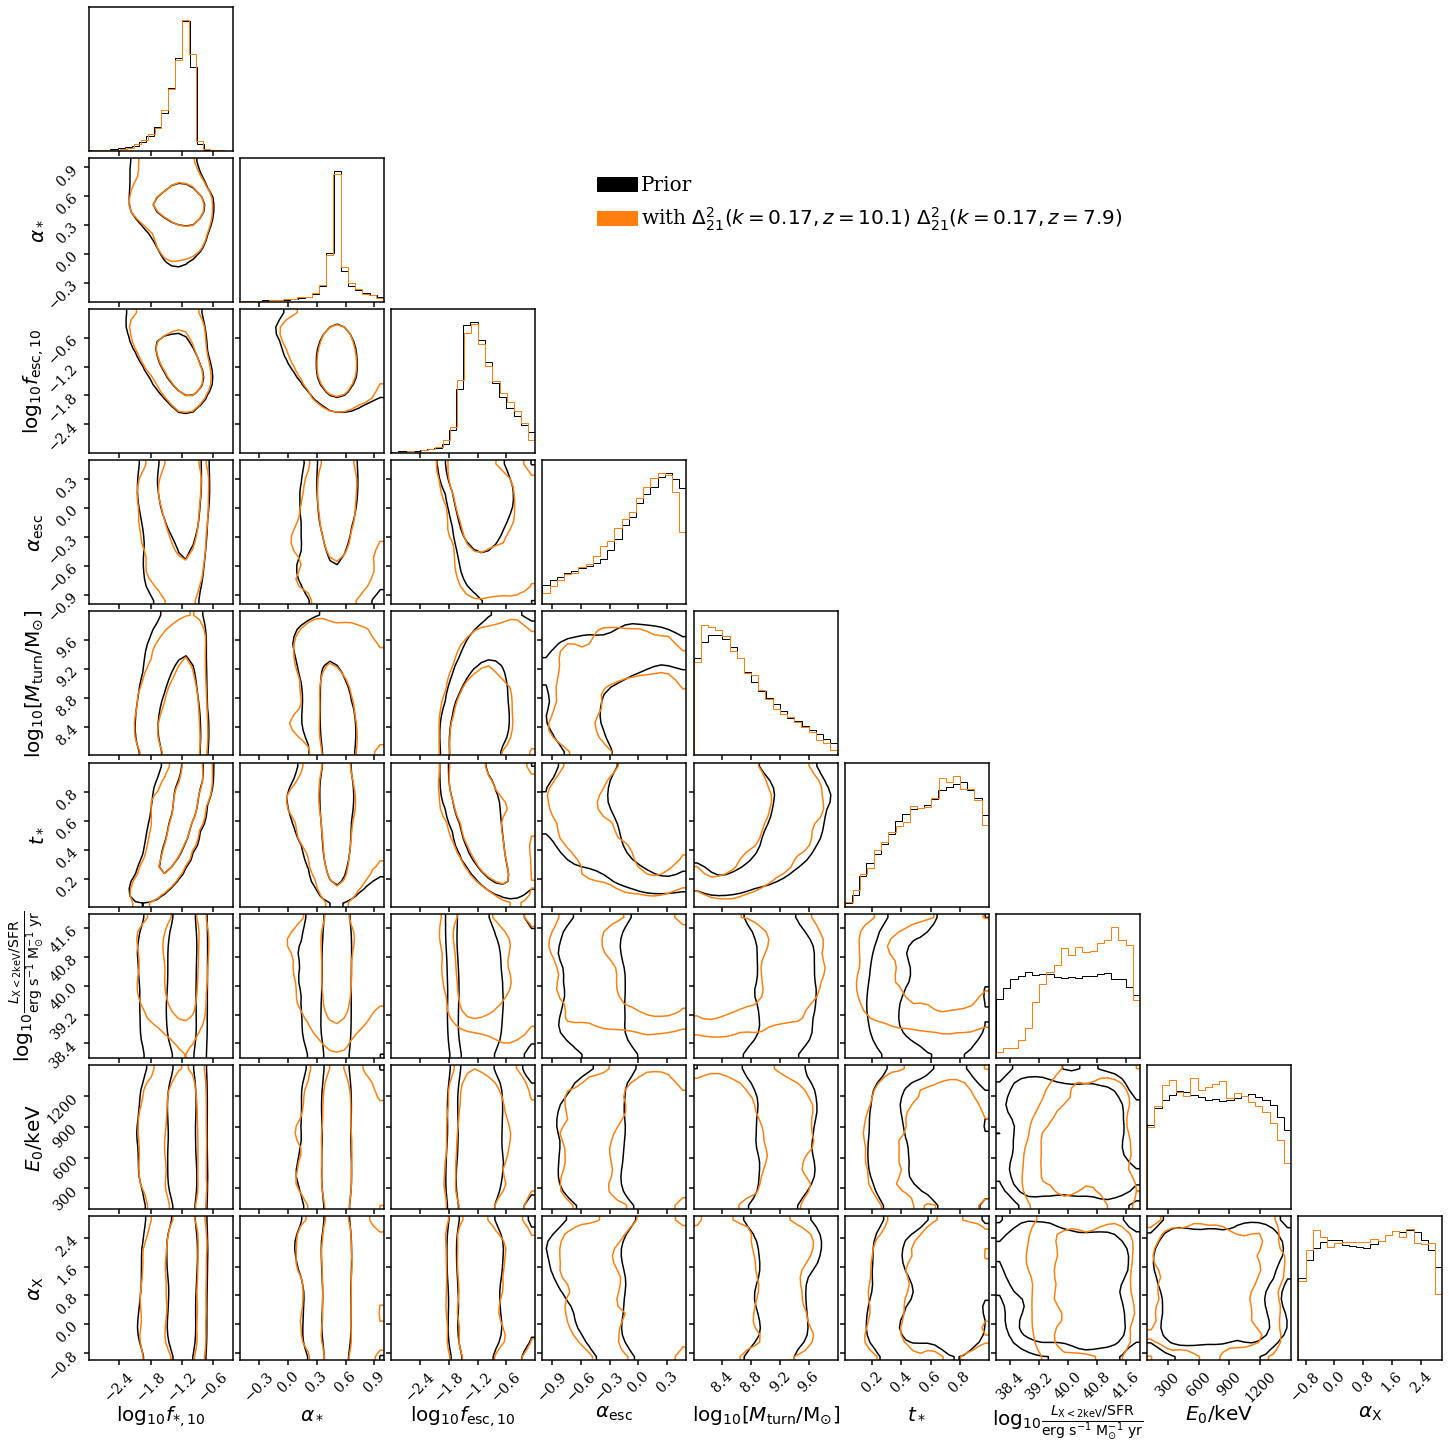

In [14]:
mcmc_npe = phat.sample((10000,),
                        x=torch.as_tensor(del2_obs.astype(np.float32)).to(device), 
                        show_progress_bars=True)
mcmc_npe = np.array(mcmc_npe.detach().to('cpu'))

fig = DFM.corner(thetas, 
                 levels=[0.68, 0.95], 
                 color='k',
                 labels=lbl_params,
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)
_ = DFM.corner(mcmc_npe, color='C1', 
               levels=[0.68, 0.95], 
               labels=lbl_params,
               label_kwargs={'fontsize': 20},
               hist_kwargs={'density': True},
               smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

ndim = 9
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[1, ndim-3]
ax.fill_between([], [], [], color='k', label='Prior')
ax.fill_between([], [], [], color='C1', label=r'with $\Delta_{21}^2(k=0.17, z=10.1)$ $\Delta_{21}^2(k=0.17, z=7.9)$')
ax.legend(handletextpad=0.2, markerscale=10, fontsize=20)

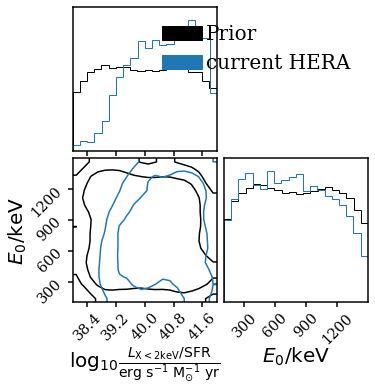

In [15]:
fig = DFM.corner(thetas[:,6:8], 
                 levels=[0.68, 0.95], 
                 color='k',
                 labels=lbl_params[6:8],
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)

_ = DFM.corner(mcmc_npe[:,6:8], color='C0', 
                   levels=[0.68, 0.95], 
                   labels=lbl_params[6:8],
                   label_kwargs={'fontsize': 20},
                   hist_kwargs={'density': True},
                   smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

ndim = 2
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[0,1]
ax.fill_between([], [], [], color='k', label='Prior')
ax.fill_between([], [], [], color='C0', label='current HERA') 
ax.legend(handletextpad=0.2, markerscale=10, fontsize=20)

## 3.2. 2x smaller thermal and systematic errors
$$\Delta_{21}^2(k=0.17 {\rm Mpc}^{-1}, z=7.9) = 100, \Delta^2_{21}(k=0.17 {\rm Mpc}^{-1}, z=10.1) = 850$$
$$\sigma_{z = 7.9} = 150, \sigma_{z = 10.1} = 1800$$
$$s_{z = 7.9} = 100, s_{z = 10.1} = 850$$

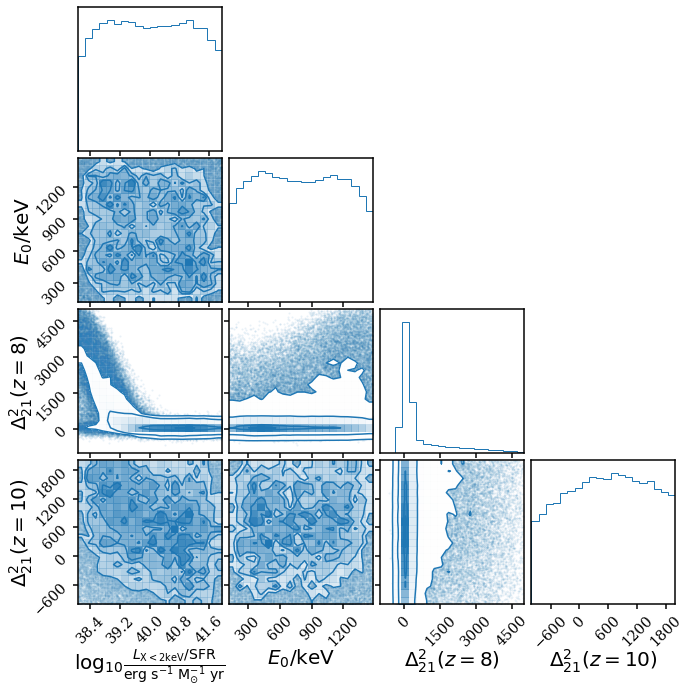

In [16]:
del2_obs = np.array([100., 850.]) 
del2_noise = apply_noise(del2_nonoise[:,:2], np.array([150., 1800.]), del2_obs)

fig = DFM.corner(np.concatenate([thetas[:,6:8], del2_noise], axis=1), color='C0',
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T[6:8]] + [(-1000., 5000), (-1000., 2000)],  
                 labels=list(lbl_params[6:8]) + [r'$\Delta_{21}^2(z=8)$', r'$\Delta_{21}^2(z=10)$'],
                 label_kwargs={'fontsize': 20})
plt.show()

In [17]:
phat = train_npe(thetas, del2_noise, n_models=1)
    
mcmc_npe = phat.sample((10000,),
                    x=torch.as_tensor(del2_obs.astype(np.float32)).to(device), 
                    show_progress_bars=True)
mcmc_npe = np.array(mcmc_npe.detach().to('cpu'))

MAF with nhidden=95; nblocks=8


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:684: UserWarning: Data x has device 'cpu' different from the training_device 'cuda:0', moving x to the training_device 'cuda:0'.
  f"Data x has device '{x.device}' "
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:692: UserWarning: Parameters theta has device 'cpu' different from the training_device 'cuda:0', moving theta to the training_device 'cuda:0'.
  f"Parameters theta has device '{theta.

 Neural network successfully converged after 141 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

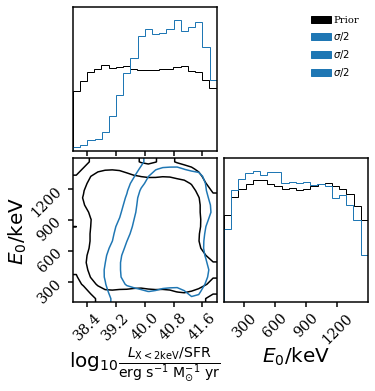

In [18]:
fig = DFM.corner(thetas[:,6:8], 
                 levels=[0.68, 0.95], 
                 color='k',
                 labels=lbl_params[6:8],
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)

_ = DFM.corner(mcmc_npe[:,6:8], color='C0', 
                   levels=[0.68, 0.95], 
                   labels=lbl_params[6:8],
                   label_kwargs={'fontsize': 20},
                   hist_kwargs={'density': True},
                   smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

ndim = 2
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[0,1]
ax.fill_between([], [], [], color='k', label='Prior')
ax.fill_between([], [], [], color='C0', label=r'$\sigma/2$') 
ax.legend(handletextpad=0.2, markerscale=10, fontsize=10)

## 3.2.1 2x smaller thermal and no systematic errors
$$\Delta_{21}^2(k=0.17 {\rm Mpc}^{-1}, z=7.9) = 0., \Delta^2_{21}(k=0.17 {\rm Mpc}^{-1}, z=10.1) = 0.$$
$$\sigma_{z = 7.9} = 150, \sigma_{z = 10.1} = 1800$$
$$s_{z = 7.9} = 0., s_{z = 10.1} = 0.$$

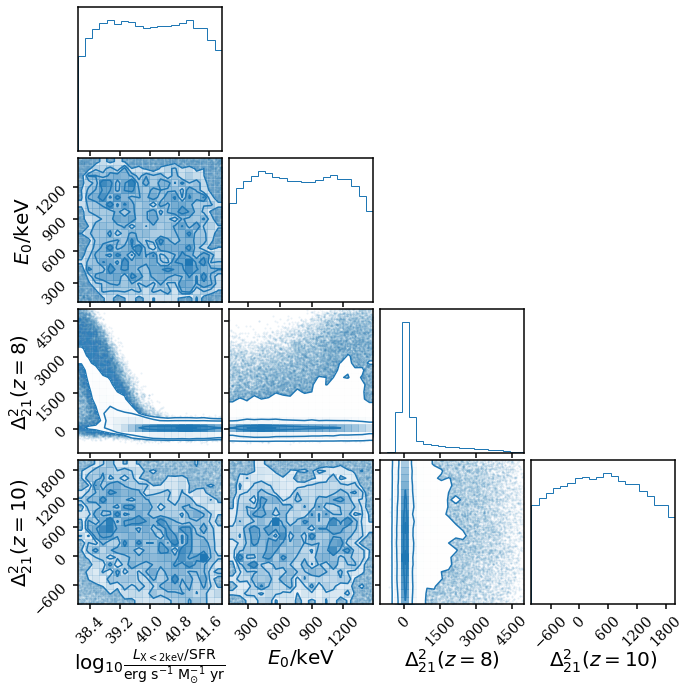

In [19]:
del2_obs = np.array([0.,  0.]) 
del2_noise = apply_noise(del2_nonoise[:,:2], np.array([150., 1800.]), del2_obs)

fig = DFM.corner(np.concatenate([thetas[:,6:8], del2_noise], axis=1), color='C0',
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T[6:8]] + [(-1000., 5000), (-1000., 2000)],  
                 labels=list(lbl_params[6:8]) + [r'$\Delta_{21}^2(z=8)$', r'$\Delta_{21}^2(z=10)$'],
                 label_kwargs={'fontsize': 20})
plt.show()

In [20]:
phat = train_npe(thetas, del2_noise, n_models=1)
    
mcmc_npe = phat.sample((10000,),
                    x=torch.as_tensor(del2_obs.astype(np.float32)).to(device), 
                    show_progress_bars=True)
mcmc_npe = np.array(mcmc_npe.detach().to('cpu'))

MAF with nhidden=67; nblocks=8


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:684: UserWarning: Data x has device 'cpu' different from the training_device 'cuda:0', moving x to the training_device 'cuda:0'.
  f"Data x has device '{x.device}' "
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:692: UserWarning: Parameters theta has device 'cpu' different from the training_device 'cuda:0', moving theta to the training_device 'cuda:0'.
  f"Parameters theta has device '{theta.

 Neural network successfully converged after 153 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

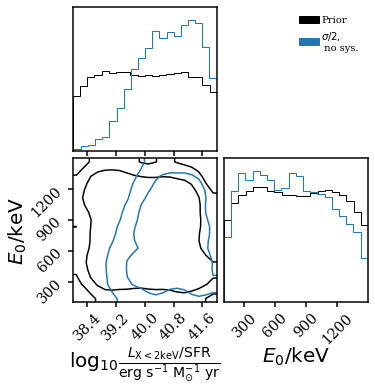

In [21]:
fig = DFM.corner(thetas[:,6:8], 
                 levels=[0.68, 0.95], 
                 color='k',
                 labels=lbl_params[6:8],
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)

_ = DFM.corner(mcmc_npe[:,6:8], color='C0', 
                   levels=[0.68, 0.95], 
                   labels=lbl_params[6:8],
                   label_kwargs={'fontsize': 20},
                   hist_kwargs={'density': True},
                   smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

ndim = 2
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[0,1]
ax.fill_between([], [], [], color='k', label='Prior')
ax.fill_between([], [], [], color='C0', label=r'$\sigma/2$,'+'\n no sys.') 
ax.legend(handletextpad=0.2, markerscale=10, fontsize=10)

## 3.3 2x smaller thermal, no systematics, $z = 8, 10, 12$
$$\Delta_{21}^2(k=0.17 {\rm Mpc}^{-1}, z=7.9) = 0., \Delta^2_{21}(k=0.17 {\rm Mpc}^{-1}, z=10.1) = 0., \Delta^2_{21}(k=0.17 {\rm Mpc}^{-1}, z=12) = 0.$$
$$\sigma_{z = 7.9} = 150, \sigma_{z = 10.1} = 1800, \sigma_{z = 12} = 4300$$
$$s_{z = 8} = 0., s_{z = 10.} = 0., s_{z = 12} = 0.$$

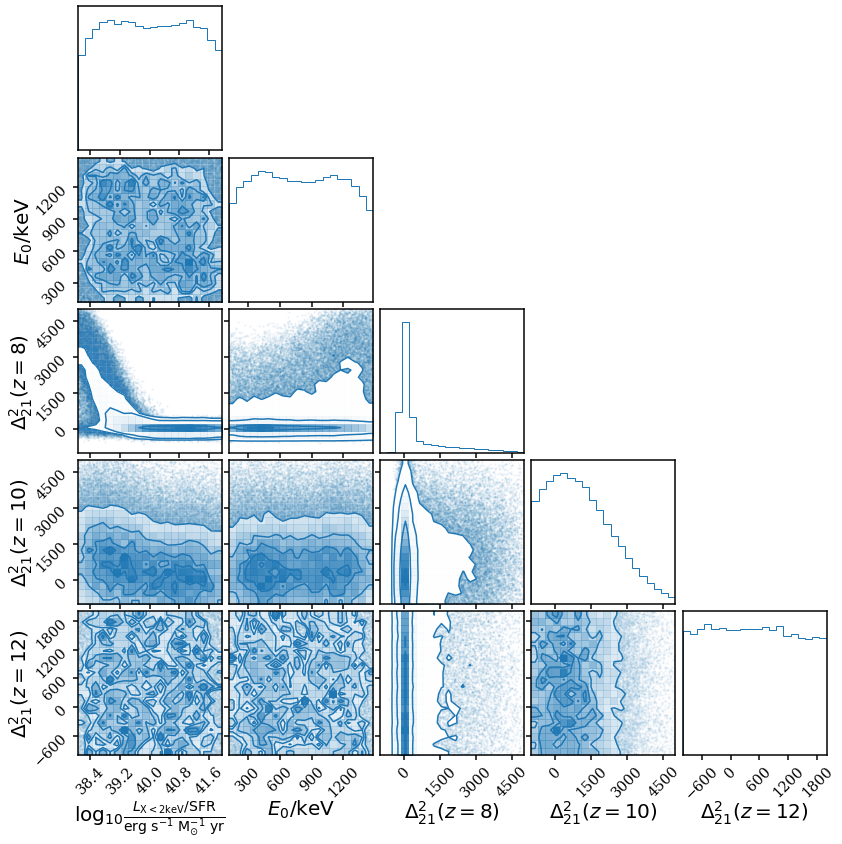

In [22]:
del2_obs = np.array([0., 0., 0.]) 
del2_noise = apply_noise(del2_nonoise[:,:3], np.array([150., 1800., 4300.]), del2_obs)

fig = DFM.corner(np.concatenate([thetas[:,6:8], del2_noise], axis=1), color='C0',
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T[6:8]] + [(-1000., 5000), (-1000., 5000), (-1000., 2000)],  
                 labels=list(lbl_params[6:8]) + [r'$\Delta_{21}^2(z=8)$', r'$\Delta_{21}^2(z=10)$', r'$\Delta_{21}^2(z=12)$'],
                 label_kwargs={'fontsize': 20})
plt.show()

In [23]:
phat = train_npe(thetas, del2_noise, n_models=1)
    
mcmc_npe = phat.sample((10000,),
                    x=torch.as_tensor(del2_obs.astype(np.float32)).to(device), 
                    show_progress_bars=True)
mcmc_npe = np.array(mcmc_npe.detach().to('cpu'))

MAF with nhidden=72; nblocks=9


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:684: UserWarning: Data x has device 'cpu' different from the training_device 'cuda:0', moving x to the training_device 'cuda:0'.
  f"Data x has device '{x.device}' "
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:692: UserWarning: Parameters theta has device 'cpu' different from the training_device 'cuda:0', moving theta to the training_device 'cuda:0'.
  f"Parameters theta has device '{theta.

 Neural network successfully converged after 135 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

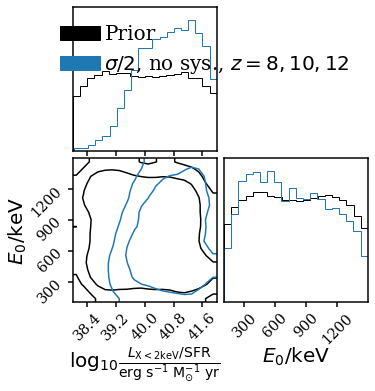

In [24]:
fig = DFM.corner(thetas[:,6:8], 
                 levels=[0.68, 0.95], 
                 color='k',
                 labels=lbl_params[6:8],
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)

_ = DFM.corner(mcmc_npe[:,6:8], color='C0', 
                   levels=[0.68, 0.95], 
                   labels=lbl_params[6:8],
                   label_kwargs={'fontsize': 20},
                   hist_kwargs={'density': True},
                   smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

ndim = 2
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[0,1]
ax.fill_between([], [], [], color='k', label='Prior')
ax.fill_between([], [], [], color='C0', label=r'$\sigma/2$, no sys., $z=8, 10, 12$') 
ax.legend(handletextpad=0.2, markerscale=10, fontsize=20)

## 3.4 2x smaller thermal, no systematics, $z = 8, 10, 12, 14, 16, 18, 20$
$$\Delta_{21}^2(k=0.17 {\rm Mpc}^{-1}, z=8, 10, 12, 14, 16, 18, 20) = 0.$$
$$\sigma_{z = 7.9} = 150, \sigma_{z = 10.1} = 1800, \sigma_{z = 12} = 4300, \sigma_{z = 14} = 9000, \sigma_{z = 16} = 17,300, \sigma_{z = 18} = 30,870, \sigma_{z = 20} = 51950$$
$$s_{z = 8, 10, 12, 14, 16, 18, 20} = 0.$$

noise is scaled by $\propto(1 + z)^{5.2}$

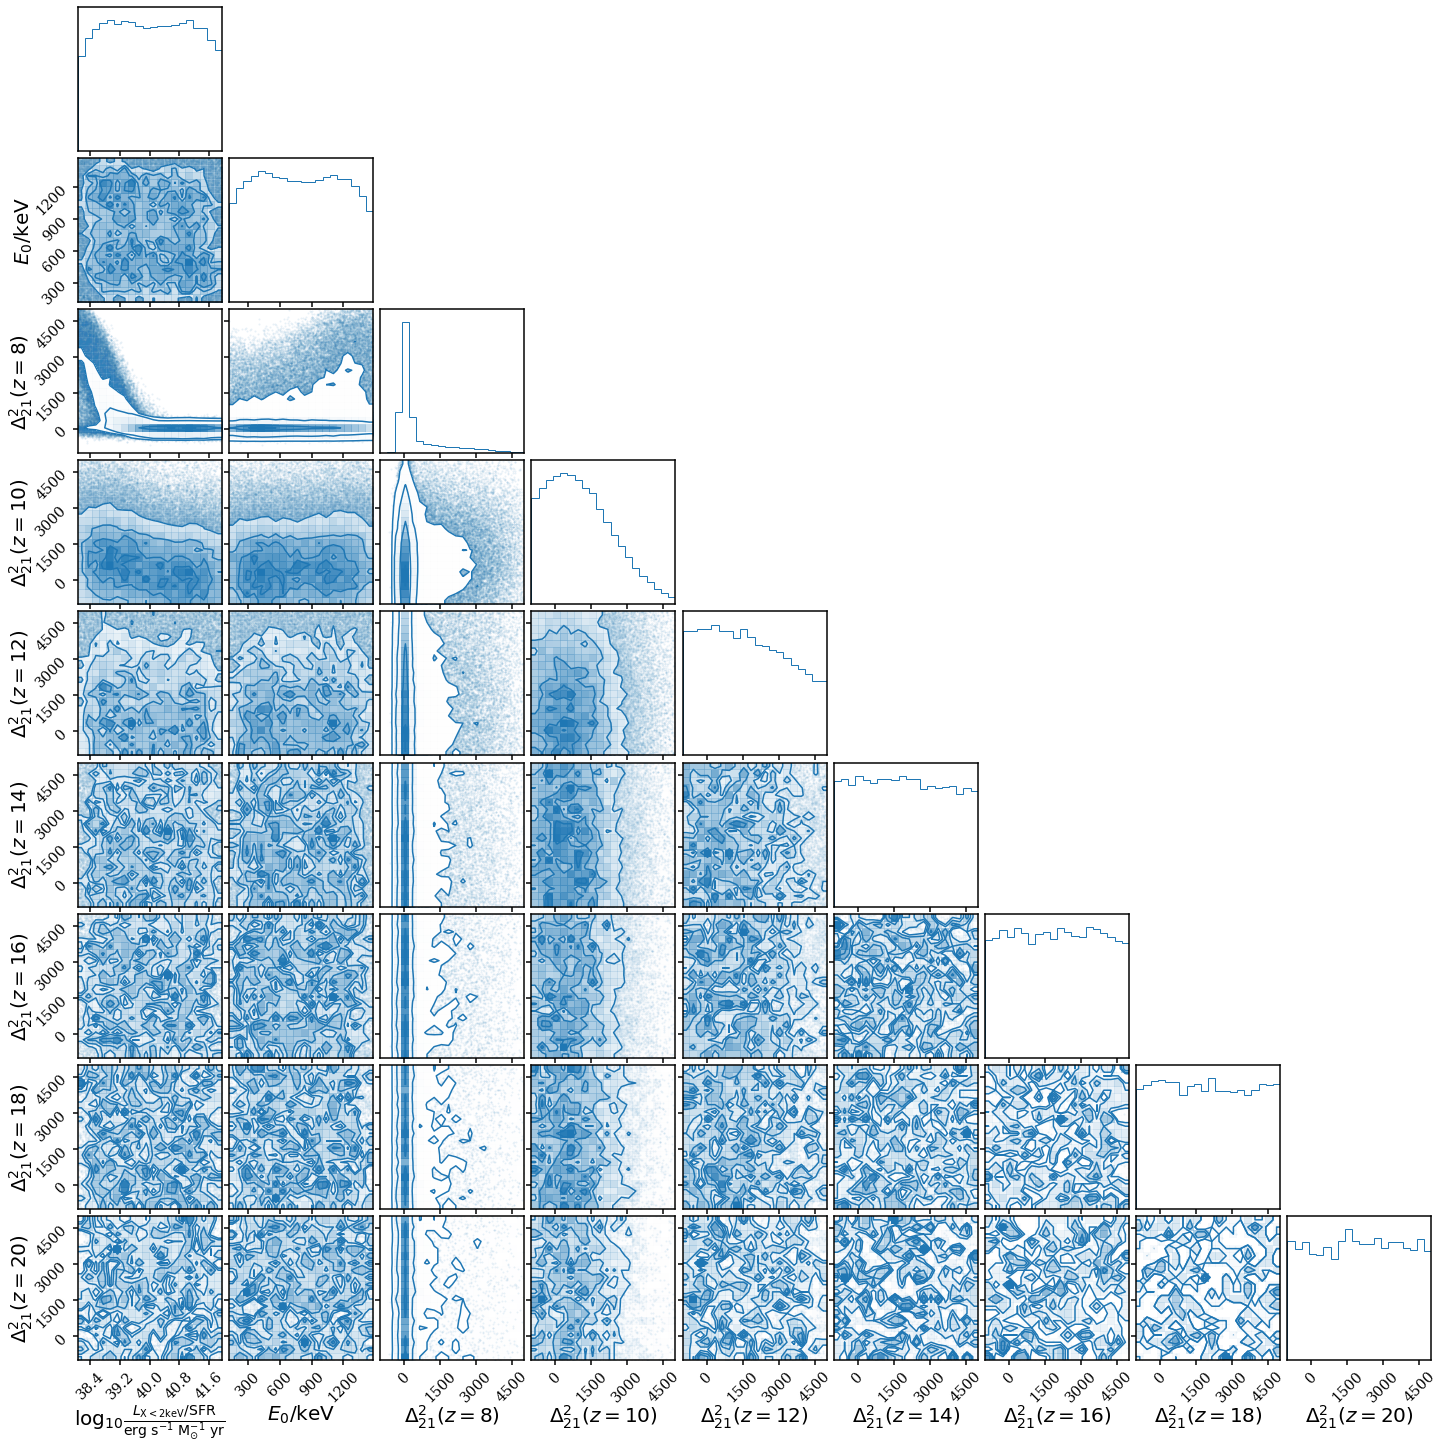

In [25]:
del2_obs = np.array([0., 0., 0., 0., 0., 0., 0.]) 
del2_noise = apply_noise(del2_nonoise, np.array([150., 1800., 4300., 9000., 17300., 30870., 51950.]), del2_obs)

fig = DFM.corner(np.concatenate([thetas[:,6:8], del2_noise], axis=1), color='C0',
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T[6:8]] + [(-1000., 5000) for i in range(7)],  
                 labels=list(lbl_params[6:8]) + [r'$\Delta_{21}^2(z=%i)$' % _z for _z in [8, 10, 12, 14, 16, 18, 20]],
                 label_kwargs={'fontsize': 20})
plt.show()

In [26]:
phat = train_npe(thetas, del2_noise, n_models=1)
    
mcmc_npe = phat.sample((10000,),
                    x=torch.as_tensor(del2_obs.astype(np.float32)).to(device), 
                    show_progress_bars=True)
mcmc_npe = np.array(mcmc_npe.detach().to('cpu'))

MAF with nhidden=78; nblocks=3


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/torchutils.py:28: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  "GPU was selected as a device for training the neural network. "
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:684: UserWarning: Data x has device 'cpu' different from the training_device 'cuda:0', moving x to the training_device 'cuda:0'.
  f"Data x has device '{x.device}' "
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/sbi/utils/user_input_checks.py:692: UserWarning: Parameters theta has device 'cpu' different from the training_device 'cuda:0', moving theta to the training_device 'cuda:0'.
  f"Parameters theta has device '{theta.

 Neural network successfully converged after 215 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

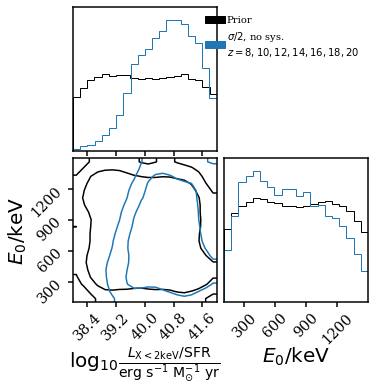

In [29]:
fig = DFM.corner(thetas[:,6:8], 
                 levels=[0.68, 0.95], 
                 color='k',
                 labels=lbl_params[6:8],
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)

_ = DFM.corner(mcmc_npe[:,6:8], color='C0', 
                   levels=[0.68, 0.95], 
                   labels=lbl_params[6:8],
                   label_kwargs={'fontsize': 20},
                   hist_kwargs={'density': True},
                   smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

ndim = 2
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[0,1]
ax.fill_between([], [], [], color='k', label='Prior')
ax.fill_between([], [], [], color='C0', label=r'$\sigma/2$, no sys.'+'\n'+r'$z=8, 10, 12, 14, 16, 18, 20$') 
ax.legend(handletextpad=0.2, markerscale=10, fontsize=10)